In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
names = open("names2.txt","r").read().split("\n")
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
chars = sorted(set("".join(names)))

In [4]:
len(chars)

26

In [5]:
#itos = dict()
#stoi = dict()

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i: s for s, i in stoi.items()}

In [6]:
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [7]:
"""prepare x, y
    x e purvite tri charactera ot dumite, kato v nachaloto sa tri tochki
    y e defakto chetvurtiq character sled tretite"""

'prepare x, y\n    x e purvite tri charactera ot dumite, kato v nachaloto sa tri tochki\n    y e defakto chetvurtiq character sled tretite'

In [8]:
X, y = [], []

In [9]:
block_size = 3

for w in names:
    context = block_size * [0]
    for ch in w + ".":
        idx = stoi[ch]
        X.append(context)
        y.append(idx)
        context = context[1:] + [idx]

X = torch.tensor(X)
y = torch.tensor(y)

In [10]:
X[0], y[0]

(tensor([0, 0, 0]), tensor(5))

In [11]:
len(X)

228147

In [12]:
n1 = int(0.8*len(X))
n1

182517

In [13]:
n2 = int(0.9*len(X))

In [14]:
Xtr, Ytr = X[:n1], y[:n1]
Xtest, Ytest = X[n1:n2], y[n1:n2]
Xdev, Ydev = X[n2:], y[n2:]

In [15]:
C = torch.randn((27,2))

In [16]:
r = torch.randn(5,5)
xtr = torch.randint(0,5,(2,2), dtype=torch.long)
print(r.shape)
print(xtr.shape)
print(r[xtr].shape)
r[xtr]

torch.Size([5, 5])
torch.Size([2, 2])
torch.Size([2, 2, 5])


tensor([[[ 1.3270, -1.7552, -0.8155, -0.4593,  0.6982],
         [ 0.0300, -0.5009, -1.5291,  1.3961,  0.5216]],

        [[ 1.3270, -1.7552, -0.8155, -0.4593,  0.6982],
         [ 0.3395,  0.4225,  0.2092,  1.7529,  1.2053]]])

In [17]:
r

tensor([[ 0.0300, -0.5009, -1.5291,  1.3961,  0.5216],
        [ 1.3270, -1.7552, -0.8155, -0.4593,  0.6982],
        [-1.2592, -1.3035, -0.1389,  0.4660, -1.7260],
        [-1.0570, -0.1108,  0.9054,  0.2085, -1.0275],
        [ 0.3395,  0.4225,  0.2092,  1.7529,  1.2053]])

In [18]:
xtr

tensor([[1, 0],
        [1, 4]])

In [19]:
Xtr.shape

torch.Size([182517, 3])

In [20]:
C[Xtr].shape

torch.Size([182517, 3, 2])

In [21]:
embedding = C[Xtr]

In [22]:
embedding.shape

torch.Size([182517, 3, 2])

In [23]:
g = torch.Generator().manual_seed(42)

w1 = torch.randn((6, 100), requires_grad=True)
b1 = torch.randn(100, requires_grad=True)

w2 = torch.randn((100,27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)

In [24]:
#forward pass
emb_resized = embedding.view(-1, 6)

In [25]:
logits1 = torch.tanh((emb_resized @ w1) + b1)
logits1.shape

torch.Size([182517, 100])

In [26]:
logits2 = (logits1 @ w2) + b2
logits2.shape

torch.Size([182517, 27])

In [27]:
exp_logits = torch.exp(logits2)

In [28]:
softmax_layer = exp_logits / exp_logits.sum(1, keepdims=True)

In [29]:
softmax_layer[0].sum()

tensor(1., grad_fn=<SumBackward0>)

In [30]:
softmax_layer.shape

torch.Size([182517, 27])

In [31]:
Ytr.shape

torch.Size([182517])

In [32]:
loss = -softmax_layer[torch.arange(0,182517), Ytr].log().mean()

In [33]:
# training loop:

In [34]:
parameters = [C, w1, w2, b1, b2]

In [35]:
for param in parameters:
    param.requires_grad = True

In [36]:
lossi = []
stepi = []

In [37]:
for i in range(200_000):
    ix = torch.randint(embedding.shape[0], (32, ))
    
    emb = C[Xtr[ix]].view(32, -1)
    
    out1 = torch.tanh((emb @ w1) + b1)
    
    out2 = (out1 @ w2) + b2
    
    exp_out = torch.exp(out2)
    softmax_layer = exp_out / exp_out.sum(1, keepdims=True)
    loss = -softmax_layer[torch.arange(32), Ytr[ix]].log().mean()
    
    
    #loss_f = F.cross_entropy(out2, Ytr[ix])
    
    for elem in parameters:
        elem.grad = None
    
    loss.backward()
    
    
    for elem in parameters:
        if i < 100_000:
            lr = 0.1
        elif i > 100_000 and i < 150_000:
            lr = 0.01
        else:
            lr = 0.001
            
        elem.data += -lr * elem.grad
    
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss)

tensor(2.4956, grad_fn=<NegBackward0>)


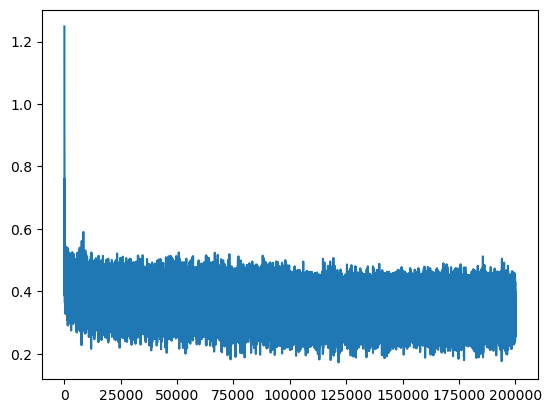

In [38]:
plt.plot(stepi, lossi)

In [39]:
emb = C[Xtr]
emb = emb.view(-1, 6)
out1 = torch.tanh((emb @ w1) + b1)
out2 = (out1 @ w2) + b2
loss = F.cross_entropy(out2, Ytr)
loss.item()

2.225853204727173

In [40]:
emb = C[Xtest]
emb = emb.view(-1, 6)
out1 = torch.tanh((emb @ w1) + b1)
out2 = (out1 @ w2) + b2
loss = F.cross_entropy(out2, Ytest)
loss.item()

2.4670512676239014

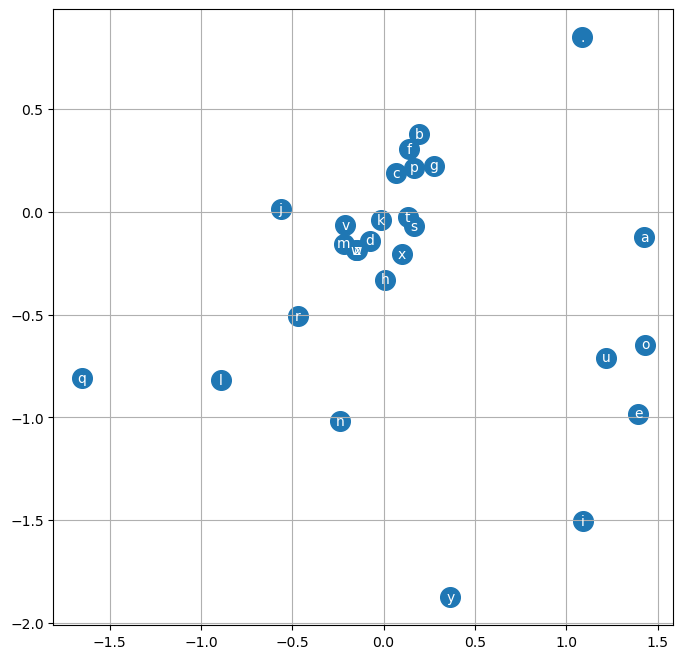

In [41]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [42]:
context = [0] * block_size
print(context)
print(C.shape)
C[torch.tensor([context])].shape

[0, 0, 0]
torch.Size([27, 2])


torch.Size([1, 3, 2])

In [44]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(10):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

junide.
jakalah.
presay.
adin.
koi.
ritolian.
juer.
kalinah.
yamilenias.
dedailr.
